# Libraries Used

In [ ]:
import requests
import os
import json
import gdal
import subprocess
import urllib.request
from PIL import Image as pilimg
from IPython.display import Image


# Defining Functions

In [ ]:
def get_coords(geojson_path):
  aoi = json.load(open(geojson_path))
  coords = aoi['features'][0]['geometry']['coordinates'][0]
  low_latitude = coords[0][0]
  high_latitude = coords[1][0]
  low_longitude = coords[0][1]
  high_longitude = coords[2][1]
  tempcoords = [low_latitude, low_longitude, high_latitude, high_longitude]
  return ','.join(map(str, tempcoords))

In [ ]:
def get_quad_urls(api_key, mosaic_name, aoi_coords):
  #setup API KEY and basemap URL
  PLANET_API_KEY = api_key
  API_URL = "https://api.planet.com/basemaps/v1/mosaics"

  #setup and authenticate session
  session = requests.Session()
  session.auth = (PLANET_API_KEY, "") #<= change to match variable for API Key if needed

  #set search parameters with mosaic name
  parameters = {
      "name__is" :"global_monthly_2022_04_mosaic" # <= customize to your use case
  }
  #make get request to access mosaic from basemaps API
  res = session.get(API_URL, params = parameters)
  #response status code
  print(res.status_code)

  mosaic = res.json()
  #get id
  mosaic_id = mosaic['mosaics'][0]['id']
  #search for mosaic quad using AOI
  search_parameters = {
      'bbox': aoi_coords,
      'minimal': True
  }
  #accessing quads using metadata from mosaic
  quads_url = "{}/{}/quads".format(API_URL, mosaic_id)
  res = session.get(quads_url, params=search_parameters, stream=True)
  print(res.status_code)

  quads = res.json()
  items = quads['items']

  print(f"Number of quads: {len(items)}")
  #printing an example of quad metadata
  return items


In [ ]:
def download_quads(urls, directory):
  os.chdir(directory)
  if 'imgs' not in os.listdir():
    os.makedirs('imgs')
  for i in urls:
     link = i['_links']['download']
     name = i['id']
     name = name + '.tiff'
     DIR = f'{directory}/imgs/' 
     filename = os.path.join(DIR, name)

     #checks if file already exists before s
     if not os.path.isfile(filename):
         urllib.request.urlretrieve(link, filename = filename)


In [ ]:
def combine_crop_quads(directory, aoi_name, geojson_path):
  directory = directory + '/imgs/'

  imglist = []

  # iterate over directory and create list of all file paths 
  for root, dirs, files in os.walk(directory):
      for file in files:
          imglist.append(os.path.join(root,file))

  # merge images in directory        
  subprocess.call(['gdal_merge.py', '-v'] + imglist + ['-o', f'/content/{aoi_name}_merged.tif'])

  # crop merged image to fit AOI and save as TIFF
  subprocess.call(['gdalwarp', '-of', 'GTiff', '-cutline', geojson_path, '-crop_to_cutline', f'/content/{aoi_name}_merged.tif', f'/content/{aoi_name}.tif'])

  # convert TIF to JPG and save image
  im = pilimg.open(f'{aoi_name}.tif')
  rgb_im = im.convert('RGB')
  rgb_im.save(f'/content/{aoi_name}.jpg', 'JPEG')

In [ ]:
def prepare_images(api_key, mosaic_name, directory, aoi_name, geojson_path):
  coords = get_coords(geojson_path)

  urls = get_quad_urls(api_key, mosaic_name, coords)

  download_quads(urls, directory)

  combine_crop_quads(directory, aoi_name, geojson_path)

# Download Images


In [ ]:
razazah = get_coords('/content/razazah.geojson')
razazah

'43.38947296142578,32.34168110749222,43.620872497558594,32.54681317351514'

In [ ]:
prepare_images('PLAKf903b158550e4eaea88078f683420efa', 'global_monthly_2022_04_mosaic', '/content', 'razazah', '/content/razazah.geojson')

In [ ]:
urls = get_quad_urls('PLAKf903b158550e4eaea88078f683420efa', 'global_monthly_2022_04_mosaic', razazah)

200
200
Number of quads: 6


In [ ]:
download_quads(urls, '/content')

In [ ]:
combine_crop_quads('/content', 'razazah', '/content/lake_razazah.geojson')

In [ ]:
im = pilimg.open('razazah_merged.tif')
rgb_im = im.convert('RGB')
rgb_im.save('/content/razazah_merged.jpg', 'JPEG')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (150994944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


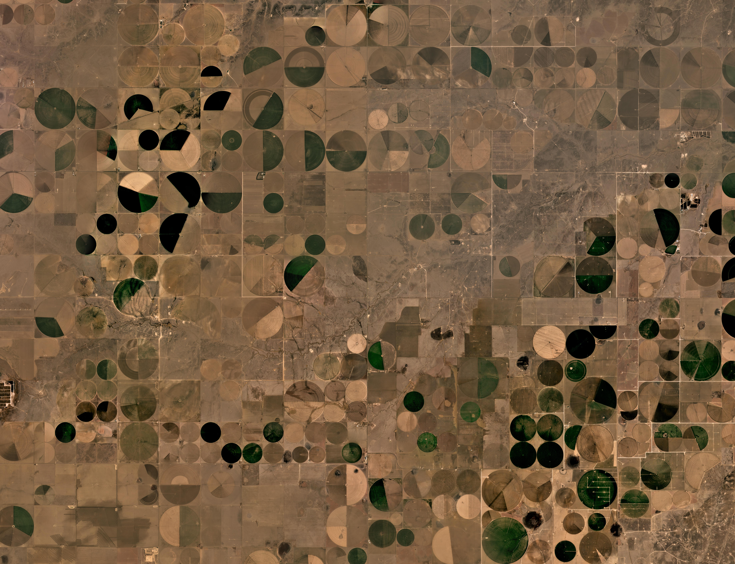

In [ ]:
aoi_png = pilimg.open('/content/razazah.jpg')
aoi_png.resize((aoi_png.getbbox()[2] // 10, aoi_png.getbbox()[3] // 10))

In [ ]:
type(urls)

list